<a href="https://colab.research.google.com/github/fringewidth/felineflow/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Train FelineFlow**
In this notebook, we will train a diffusion model to generate 256x256 images of cats🐈

## Setup
Let's use Google's TPUs to speed up the training process, and also import other necessary modules.

In [3]:
!pip install torch-xla

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: uritemplate
    Found existing installation: uritemplate 4.1.1
    Uninstalling uritemplate-4.1.1:
      Successfully uninstalled uritemplate-4.1.1
  Attempting uninstall: google-api-core
    Found existing installation: google-api-core 2.11.1
    Uninstalling google-api-core-2.11.1:
      Successfully uninstalled google-api-core-2.11.1
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.84.0
    Uninstalling google-api-python-client-2.84.0:
      Successfully uninstalled google-api-python-client-2.84.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency con

In [4]:
import torch_xla
import torch_xla.core.xla_model as xm
import matplotlib.pyplot as plt
from google.colab import drive
import torch
import torchvision

In [5]:
dev = xm.xla_device()

## 🔃Loading cute cats...
Let's import the dataset. I've used 4096 images of cats from [Microsoft Research's Cats vs. Dogs Dataset.](https://www.microsoft.com/en-us/download/details.aspx?id=54765)
I've cropped the data to a 256x256 resolution.
The processed data is available [here](https://github.com/fringewidth/felineflow/blob/main/cats_processed.zip) as a `.zip`.


In [ ]:
#get dataset
!wget https://github.com/fringewidth/felineflow/raw/main/cats_processed.zip
!mkdir -p dataset/cats
!unzip cats_processed.zip -d dataset/cats

In [7]:
cats = torchvision.datasets.ImageFolder(root='dataset', transform = torchvision.transforms.ToTensor())

In [8]:
#get dataloader
cats_loader = torch.utils.data.DataLoader(cats, batch_size=64, shuffle=True)

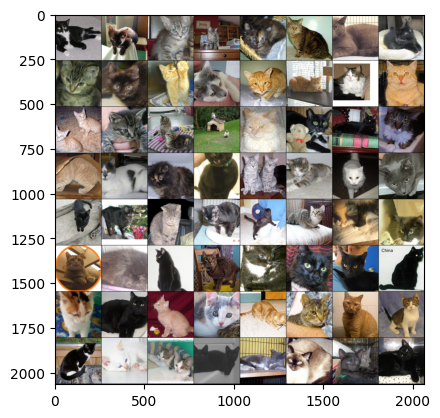

In [9]:
#get sample batch
sample_batch, labels = next(iter(cats_loader))

#make grid image
grid = torchvision.utils.make_grid(sample_batch)

#convert CHW(channels, height, width) to HWC and display
grid = grid.permute(1,2,0)
plt.imshow(grid)

## **Forward Diffusion**
Let's now implement the forward diffusion process

In [22]:
#function to get a linear noise schedule
def get_noise_schedule(start, end, timesteps):
  beta = torch.linspace(start, end, timesteps)
  alpha = 1 - beta
  alpha_bar = torch.cumprod(alpha, dim=0)
  return beta, alpha, alpha_bar

In [82]:
def get_noised_image(image, alpha_bar, t):
  image_t = image * torch.sqrt(alpha_bar[t]) + torch.sqrt((1-alpha_bar[t]))*torch.randn_like(image)
  return image_t

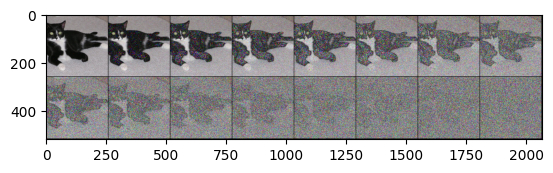

In [137]:
#test forward diffusion
sample_steps=16
beta, alpha, alpha_bar = get_noise_schedule(1e-4, 0.02, sample_steps)
img_arr = torch.empty(sample_steps,3,256,256)
for t in range(sample_steps):
  img_arr[t] = (get_noised_image(sample_batch[0], alpha_bar, t)*255).type(torch.uint8)

noised_grid = torchvision.utils.make_grid(img_arr).permute(1,2,0)
plt.imshow(noised_grid.type(torch.uint8))

In [27]:
sample_batch[0].size()

torch.Size([3, 256, 256])